In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import sys
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_bool_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from rfpimp import *

In [60]:
input_df = sys.argv[1]
majority_fraction = float(sys.argv[2])
approach = sys.argv[3]
n_estimators = int(sys.argv[4])
min_samples_split = int(sys.argv[5])
min_samples_leaf = int(sys.argv[6])
max_features = sys.argv[7]
max_depth = sys.argv[8]
bootstrap = eval(sys.argv[9])

ValueError: could not convert string to float: '--stdin=9110'

In [2]:
input_df = '../gene_info.genes_tes_gc.lengths_effectors.guy11_histone_expression.go_pfam_eccdnas.txt'
majority_fraction =  0.025 ## just to get trues and falses balanced well
approach = 'RF'
n_estimators = 250
min_samples_split =  2
min_samples_leaf = 1
max_features = 'sqrt'
max_depth = '100'
bootstrap = 'True'

In [94]:
def none_or_str(value):
    if value == 'None':
        return None
    return value

max_features = none_or_str(max_features)


def none_or_int(value):
    if value == 'None':
        return None
    return int(value)

max_depth = none_or_int(max_depth)

In [95]:
args_dict = {
    "n_estimators": n_estimators,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "max_features": max_features,
    "max_depth": max_depth,
    "bootstrap": bootstrap
}

In [4]:
def reports(model, X_test, y_test):
    y_pred = model.predict(X_test)
    TP = len(y_pred[(y_pred == 1) & (y_test == 1)])
    FN = len(y_pred[(y_pred == 0) & (y_test == 1)])
    FP = len(y_pred[(y_pred == 1) & (y_test == 0)])
    # sensitivity, how sensitive is the test? TP/TP+FN aka recall
    recall = TP/(TP+FN)
    ## PPV, how powerful is a positive? TP/TP+FP aka precision
    precision = TP/(TP+FP)
    ap = average_precision_score(y_test, model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return([recall, precision, ap, auc])

def train_test_split_mine_downsample(majority_fraction):
    df_genes = pd.read_csv(input_df)
    df_genes = df_genes[df_genes['lineage']!=4]
    ## pick 4 genomes per lineage as testing data
    genome_test_subset = []
    for lineage in np.unique(df_genes.lineage):
        for genome in np.random.choice(df_genes[df_genes.lineage == lineage].genome, size=4,replace=False):
            genome_test_subset.append(genome)
    df_genes_test_subset = df_genes[df_genes.genome.isin(genome_test_subset)]
    df_genes = df_genes[~df_genes.genome.isin(genome_test_subset)]
    if majority_fraction != 1.0:
        pav_true_subset = df_genes[df_genes['lineage_pav']==True].id
        pav_false_subset_downsampled = np.random.choice(df_genes[df_genes['lineage_pav'] == False].id, size=int(len(df_genes.index)*majority_fraction),replace=False)
        df_genes_downsampled = df_genes[(df_genes.id.isin(pav_false_subset_downsampled)) | (df_genes.id.isin(pav_true_subset))]
    else:
        df_genes_downsampled = df_genes
    # drop columns
    df_genes_downsampled = df_genes_downsampled.drop(['id', 'scaffold', 'start', 'end', 'orientation', 'orthogroups', 'enough_space_te', 'enough_space_gene',
                            'genome', 'lineage', 'lineage_conserved', 'proportion'], axis=1)
    df_genes_test_subset = df_genes_test_subset.drop(['id', 'scaffold', 'start', 'end', 'orientation', 'orthogroups', 'enough_space_te', 'enough_space_gene',
                            'genome', 'lineage', 'lineage_conserved', 'proportion'], axis=1)
    y_train = df_genes_downsampled['lineage_pav']
    X_train = df_genes_downsampled.drop('lineage_pav', axis=1)
    y_test = df_genes_test_subset['lineage_pav']
    X_test = df_genes_test_subset.drop('lineage_pav', axis=1)
    return(y_train,X_train,y_test,X_test)

In [5]:
y_train,X_train,y_test,X_test = train_test_split_mine_downsample(majority_fraction)

In [8]:
for col in X_train:
    print(col)

any_te
DNA
DNA/CMC-EnSpm
DNA/hAT-Ac
DNA/Kolobok-H
DNA/MULE-MuDR
DNA/Tc-Mar
DNA/TcMar-Fot1
DNA/TcMar-Pogo
LINE/CRE
LINE/Penelope
LINE/R2-NeSL
LINE/Tad1
LTR/Copia
LTR/Gypsy
LTR/Pao
LTR/Unknown
Unknown
gene_nearby
gene_gc
flanking_1kb_gc
flanking_5kb_gc
lengths
tm
signalp
effectorp
H3K27ac
H3K27me3
H3K36me3
cm_expression
ip_expression
eccdna_cov
eccdnasr_cov
go
pfam


In [ ]:
if approach == "SMOTE":
    oversample = SMOTE()
    over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)
    X_train = over_X_train
    y_train = over_y_train
if approach == "BRFC":
    model = BalancedRandomForestClassifier(**args_dict)
elif approach == "RF_balanced":
    model = RandomForestClassifier(class_weight="balanced", **args_dict)
elif approach == "RF_balanced_subsample":
    model = RandomForestClassifier(class_weight="balanced_subsample", **args_dict)
elif approach == "RF":
    model = RandomForestClassifier(**args_dict)
elif approach == "SMOTE":
    model = RandomForestClassifier(**args_dict)

In [ ]:
def sample_rows(X, n_samples):
    if n_samples < 0: n_samples = len(X)
    n_samples = min(n_samples, len(X))
    if n_samples < len(X):
        ix = np.random.choice(len(X), n_samples)
        X = X.iloc[ix].copy(deep=False)  # shallow copy
    return X

In [102]:
def oob_dependences(args_dict, X_train, n_samples=5000):
    numcols = [col for col in X_train if not is_bool_dtype(X_train[col])]
    boolcols = [col for col in X_train if is_bool_dtype(X_train[col])]
    X_train = sample_rows(X_train, n_samples)
    df_dep = pd.DataFrame(columns=['Feature','Dependence'])
    df_dep = df_dep.set_index('Feature')
    rf = RandomForestRegressor(oob_score=True,**args_dict)
    for col in numcols:
        X, y = X_train.drop(col, axis=1), X_train[col]
        rf.fit(X, y)
        df_dep.loc[col] = rf.oob_score_
    rf = RandomForestClassifier(oob_score=True,**args_dict)
    for col in boolcols:
        X, y = X_train.drop(col, axis=1), X_train[col]
        rf.fit(X, y)
        df_dep.loc[col] = rf.oob_score_    
    df_dep = df_dep.sort_values('Dependence', ascending=False)
    return df_dep

In [103]:
df_dep = oob_dependences(args_dict, X_train)

In [104]:
df_dep

,Dependence
Feature,
LINE/Penelope,1.000000
LTR/Pao,1.000000
DNA/MULE-MuDR,1.000000
DNA/hAT-Ac,1.000000
LINE/CRE,0.999600
DNA/Kolobok-H,0.999600
any_te,0.999200
DNA/TcMar-Pogo,0.998800
LTR/Unknown,0.997800


In [122]:
def feature_dependence_matrix_mine(X_train,
                              rfrmodel=RandomForestRegressor(**args_dict, oob_score=True),
                              rfcmodel=RandomForestClassifier(**args_dict, oob_score=True),
                              zero=0.001,
                              sort_by_dependence=False,
                              n_samples=5000):
    all_cols = [col for col in X_train]
    boolcols = [col for col in X_train if is_bool_dtype(X_train[col])]
    X_train = sample_rows(X_train, n_samples)
    df_dep = pd.DataFrame(index=X_train.columns, columns=['Dependence']+X_train.columns.tolist())
    for i,col in enumerate(all_cols):
        X, y = X_train.drop(col, axis=1), X_train[col]
        if col in boolcols:
            rf = clone(rfcmodel)
            rf.fit(X,y)
            imp = permutation_importances_raw(rf, X, y, oob_classifier_f1_score, n_samples)
        else:
            rf = clone(rfrmodel)
            rf.fit(X,y)
            imp = permutation_importances_raw(rf, X, y, oob_regression_r2_score, n_samples)
        imp = np.clip(imp, a_min=0.0, a_max=1.0)
        imp[imp<zero] = 0.0
        imp = np.insert(imp, i, 1.0)
        df_dep.iloc[i] = np.insert(imp, 0, rf.oob_score_) # add overall dependence
    if sort_by_dependence:
        return df_dep.sort_values('Dependence', ascending=False)
    return df_dep

In [123]:
df_dep_matrix = feature_dependence_matrix_mine(X_train, sort_by_dependence=False)

In [124]:
df_dep_matrix

,Dependence,any_te,DNA,DNA/CMC-EnSpm,DNA/hAT-Ac,DNA/Kolobok-H,DNA/MULE-MuDR,DNA/Tc-Mar,DNA/TcMar-Fot1,DNA/TcMar-Pogo,...,effectorp,H3K27ac,H3K27me3,H3K36me3,cm_expression,ip_expression,eccdna_cov,eccdnasr_cov,go,pfam
any_te,0.999,1.0,0.014339,0.001895,0.0,0.0,0.0,0.039008,0.113045,0.001087,...,0.0,0.001359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNA,0.9938,0.187672,1.0,0.0,0.0,0.0,0.0,0.035054,0.018753,0.0,...,0.006134,0.025245,0.028609,0.002759,0.038611,0.025245,0.025245,0.018753,0.038611,0.012384
DNA/CMC-EnSpm,0.998,0.039524,0.0,1.0,0.0,0.0,0.0,0.0,0.083433,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNA/hAT-Ac,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNA/Kolobok-H,0.9988,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNA/MULE-MuDR,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNA/Tc-Mar,0.9826,0.157319,0.010071,0.0,0.0,0.0,0.0,1.0,0.034351,0.0,...,0.008624,0.039071,0.058522,0.02052,0.02052,0.017445,0.043847,0.039071,0.011563,0.02647
DNA/TcMar-Fot1,0.9692,0.26138,0.007321,0.004603,0.0,0.0,0.0,0.006567,1.0,0.00183,...,0.0,0.011953,0.021495,0.010582,0.013829,0.017137,0.0,0.003704,0.020127,0.003661
DNA/TcMar-Pogo,0.998,0.083433,0.0,0.0,0.0,0.0,0.0,0.0,0.012005,1.0,...,0.0,0.083383,0.083383,0.0,0.083383,0.083383,0.0,0.083383,0.0,0.0
LINE/CRE,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


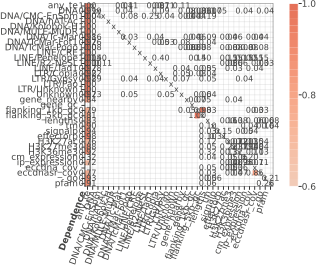

In [126]:
plot_dependence_heatmap(df_dep_matrix)

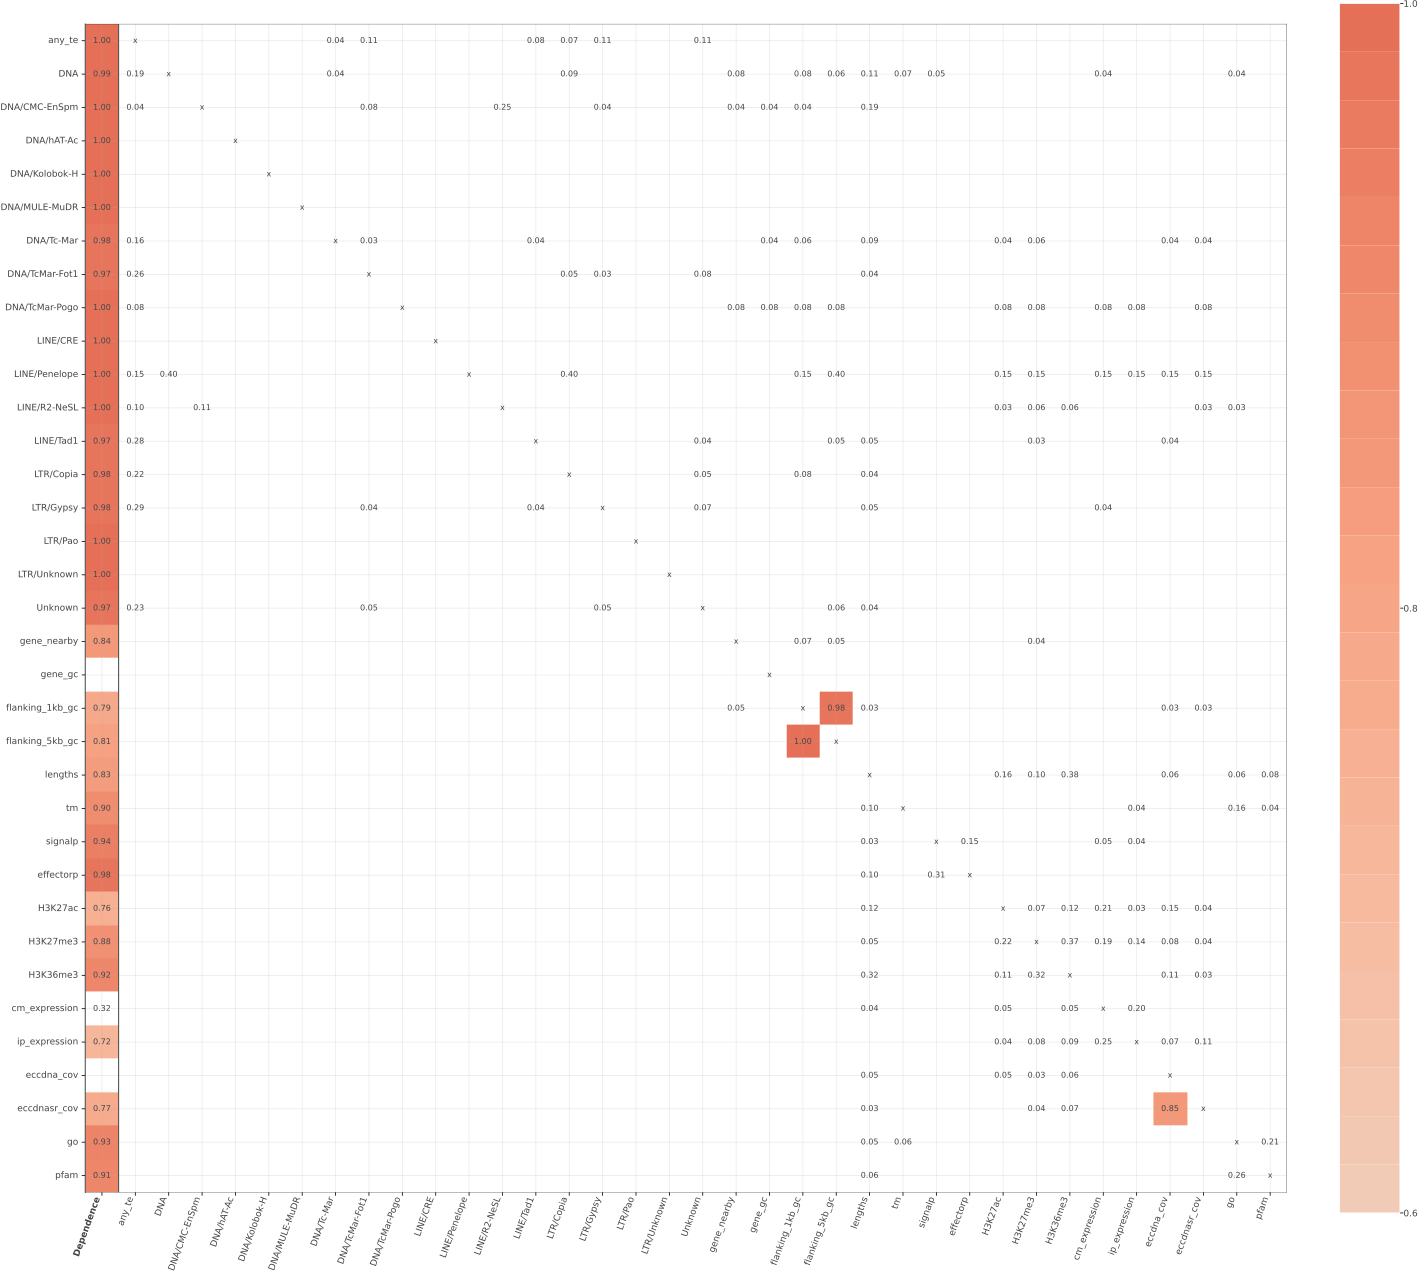

In [130]:
viz = plot_dependence_heatmap(df_dep_matrix, figsize=(20,20))
viz.save('dependence_heatmap.png')
viz